(266,)


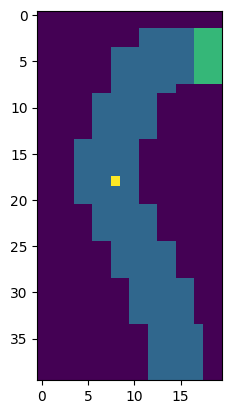

In [32]:
import numpy as np
import matplotlib.pyplot as plt

map = np.array([0]*40*20).reshape(40,20)
def show_(map,car):
    map_show = map.copy()
    map_show[car[0],car[1]] = 3
    map_show = map_show.reshape(40,20,1)
    plt.imshow(map_show)

map[-1,12:18] = 1
map[-6:-1,12:18] = 1
map[-11:-6,10:17] = 1
map[-15:-11,8:15] = 1
map[-19:-15,6:13] = 1
map[-26:-19,4:11] = 1
map[-31:-26,6:13] = 1
map[-36:-31,8:15] = 1
map[-38:-32,11:19] = 1
map[2:8,-3:] = 2
show_(map,np.array([18,8]))
print(map[map == 1].shape)
road = np.array(np.where(map == 1)).transpose(1,0)
goal = np.array(np.where(map == 2)).transpose(1,0)

velocity = np.array([0]*49*2).reshape(49,2)
for i in range(7):
    velocity[7*i:7*(i+1),0] = i - 3
    for j in range(7):
        velocity[7*i+j,1] = j - 3

In [33]:
#실제 좌표와, 이에 대응되는 인덱스값 두개를 적절히 변환해서 사용해야 함.

In [34]:
#상태를 (x좌표, y좌표, x속도, y속도) 로 할 수 있겠지만 나는 (좌표, 속도)로 하였음 각 좌표 속도는 정수로(인덱스) 대응시킴.
pi = np.array([7]*266*49).reshape(266,49) #상태(인덱스로) 넣고, 정책(0~8) 반환, 7로 초기화 하는 이유: 뭐로 초기화 하던 상관 없으나, 위로 가는게 최적정책에 가까울거 같아서
q = np.array([-300.0]*266*49*9).reshape(266,49,9) #행동가치함수
qc = np.array([0]*266*49*9).reshape(266,49,9) #평균내기 위해 몇갠지 세기
a = np.array([0]*9*2).reshape(9,2) #인덱스 넣으면 가속도 배출(a[0] == [-1,-1])
a[:3,0] = -1
a[3:6,0] = 0
a[6:9,0] = 1
for i in range(3):
    a[i*3,1] = -1
    a[i*3+1,1] = 0
    a[i*3+2,1] = 1

In [35]:
def s_index(s,v):
    return [np.intersect1d(np.where(road[:,0] == s[0]),np.where(road[:,1] == s[1]))[0], np.intersect1d(np.where(velocity[:,0] == v[0]),np.where(velocity[:,1] == v[1]))[0]]

In [ ]:
c = 0
firstgoal = False
for i in range(300000):
    if i % 3000 == 0:
        print(c/3000)
        print("--------------------")
        c = 0
    restart = False
    first = False
    #[s,v]가 상태임 (인덱스로)
    s = road[np.random.randint(266)].copy() # shape == (2,)
    v = velocity[np.random.randint(49)].copy()
    a_t = np.random.randint(9)
    #[[1,3],[4,7]] 이런식으로 리스트 안에 [s,v]를 원소로 가지도록 하는 코드
    s_list = [s_index(s,v)]
    a_list = [a_t]
    r_list = [0]
    for j in range(1000):
        if j == 299:
            restart = True
            break
        
        v[0] += a[a_t][0].copy()
        v[1] += a[a_t][1].copy()
        
        if v[0]<-3:
            v[0] = -3
        elif v[0]>3:
            v[0] = 3
        if v[1]<-3:
            v[1] = -3
        elif v[1]>3:
            v[1] = 3
            
        s[0] += v[0]
        s[1] += v[1]
        if list(s) in road.tolist():
            a_t = pi[tuple(s_index(s,v))]
            s_list.append(s_index(s,v))
            a_list.append(a_t)
            r_list.append(-1)
        elif list(s) in goal.tolist():
            c += 1
            if first == True and firstgoal == False:
                firstgoal = True
                print(i,"step First Goal!!!!!")
                #이게 출력되야 최적정책일 가능성이 조금씩 커지기 시작. 그전에는 0임
            break
        else:
            first = True
            s = np.array([39,np.random.randint(12,18)])
            v = np.array([0,0])
            a_t = pi[tuple(s_index(s,v))]
            s_list.append(s_index(s,v))
            a_list.append(a_t)
            r_list.append(-1)
    if restart == True:
        continue
    r_list.append(10) #1로 바꾸고도 성능 같은지 실험 ㄱㄱ 나중에
    g = 0
    time = len(s_list)
    time = list(range(time))[::-1]
    for t in time:
        g = g + r_list[t+1]
        qc[tuple(s_list[t]+[a_list[t]])] += 1
        q[tuple(s_list[t]+[a_list[t]])] = q[tuple(s_list[t]+[a_list[t]])] + (0.5)*(g - q[tuple(s_list[t]+[a_list[t]])])
        max = -10000
        arg = -1
        for j in range(9):
            if s_list[t][1] == 24 and j == 4:
                continue
            if q[tuple(s_list[t]+[j])] > max:
                max = q[tuple(s_list[t]+[j])]
                arg = j
        pi[tuple(s_list[t])] = arg

In [ ]:
s = np.array([39,np.random.randint(12,18)])
v = np.array([0,0])
a_t = pi[tuple(s_index(s,v))]
while True:
    show_(map,s)
    plt.show()
    v[0] += a[a_t][0].copy()
    v[1] += a[a_t][1].copy()
    if v[0]<-3:
        v[0] = -3
    elif v[0]>3:
        v[0] = 3
    if v[1]<-3:
        v[1] = -3
    elif v[1]>3:
        v[1] = 3
    s[0] += v[0]
    s[1] += v[1]
    if list(s) in road.tolist():
        a_t = pi[tuple(s_index(s,v))]
    elif list(s) in goal.tolist():
        break
    else:
        s = np.array([39,np.random.randint(12,18)])
        v = np.array([0,0])
        a_t = pi[tuple(s_index(s,v))]
show_(map,s)
plt.show()